In [174]:
#import libraries
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [58]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

In [59]:
#creating transformers 
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.scaler = StandardScaler()
        self.columns = columns
    def fit(self,X,y=None):
        if len(X[self.columns].shape) == 1:
            Xreshape = X[self.columns].to_numpy().reshape(-1,1)
            self.scaler.fit(Xreshape)
        else:
            self.scaler.fit(X[self.columns])
        return self
    def transform(self,X,y=None):
        if len(X[self.columns].shape) == 1:
            Xreshape = X[self.columns].to_numpy().reshape(-1,1)
            X[self.columns] = self.scaler.transform(Xreshape)
        else:
            X_trans = self.scaler.transform(X[self.columns])
            for i in range(len(self.columns)):
                X[self.columns[i]] = X_trans[:,i].to_numpy()
        return X
    
class Species(BaseEstimator, TransformerMixin):
    def __init__(self, tree):
        self.tree = tree
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.loc[X.species == self.tree]
        X = X.drop('species', axis=1)
        return X
    
class enc(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.enc = OneHotEncoder()
    def fit(self, X, y=None):
        self.enc.fit(X[['species','phys_class_code','grow_class_code']].to_numpy())
        return self
    def transform(self, X, y=None):
        encoded = self.enc.transform(X[['phys_class_code','grow_class_code']].to_numpy()).toarray()
        X = X.drop(['phys_class_code','grow_class_code'],axis=1).to_numpy()
        X = np.concatenate((X, encoded), axis=1)
        return X
    
class species_enc(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.enc = OneHotEncoder()
    def fit(self, X, y=None):
        self.enc.fit(X['species'].to_numpy().reshape(-1,1))
        return self
    def transform(self, X, y=None):
        encoded = self.enc.transform(X['species'].to_numpy().reshape(-1,1)).toarray()
        X = X.drop('species',axis=1).to_numpy()
        X = np.concatenate((X, encoded), axis=1)
        return X

In [60]:
#Loading the data complete with strata
county_tree_cat = pd.read_csv('county_tree_climate_cats_DMH.csv')
county_tree_cat = county_tree_cat.loc[county_tree_cat.volume !=0]

In [61]:
#Normalizing the volume and biomass to number of trees
county_tree_cat = county_tree_cat.assign(mean_volume = lambda x: x.volume/x.number_trees)
county_tree_cat = county_tree_cat.assign(mean_biomass = lambda x: x.Biomass/x.number_trees)
county_tree_cat = county_tree_cat.assign(mean_density = lambda x: x.mean_biomass/x.mean_volume)
county_tree_cat = county_tree_cat.assign(log_volume = lambda x: np.log(x.mean_volume))
county_tree_cat = county_tree_cat.assign(log_mass = lambda x: np.log(x.mean_biomass))

In [62]:
columns = ['latitude','longitude','mean_temp','mean_dwp','mean_prcp','mean_density','log_volume','log_mass','mean_volume','mean_biomass']

In [63]:
X = county_tree_cat[columns]
y = county_tree_cat['species']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

In [65]:
oe = OrdinalEncoder()

In [66]:
y_train = oe.fit_transform(y_train.to_numpy().reshape(-1,1))

In [67]:
#creating a pipeline for the transformers
preprocessing = Pipeline([('scaler', StandardScaler())])

In [68]:
X_train_prp = preprocessing.fit_transform(X_train)

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [154]:
#Testing various max depths (2-20)
depth_scores = np.empty((25,30601))

for i in range(1,26,1):
    rfc = RandomForestClassifier(max_depth=i)
    depth_scores[i-1] = list(cross_val_predict(rfc, X_train_prp, y_train.ravel(), cv=5))

In [167]:
depth_scores[7].size

30601

In [155]:
precision = np.empty(25)
recall = np.empty(25)
accuracy = np.empty(25)
for i in range(25):
    precision[i] = precision_score(y_train.ravel(), depth_scores[i], average = 'macro')
    recall[i] = recall_score(y_train.ravel(),depth_scores[i], average = 'macro')
    accuracy[i] = accuracy_score(y_train.ravel(),depth_scores[i])

/home/dan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


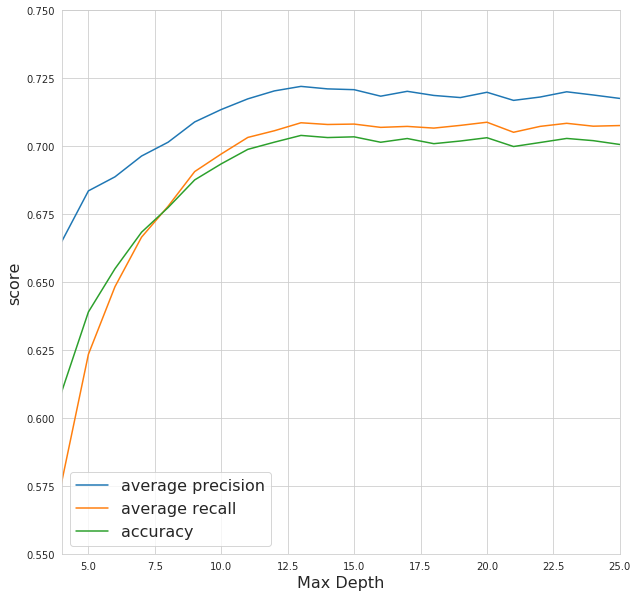

In [177]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(1,25,25),precision, label = 'average precision')
plt.plot(np.linspace(1,25,25),recall, label = 'average recall')
plt.plot(np.linspace(1,25,25),accuracy, label = 'accuracy')
plt.xlim(4,25)
plt.ylim(0.55,0.75)
plt.legend(fontsize=16)
plt.xlabel('Max Depth', fontsize=16)
plt.ylabel('score',fontsize=16)
plt.show()

In [99]:
np.linspace(5,25,5)

array([ 5., 10., 15., 20., 25.])

In [103]:
recall

array([0.63870462, 0.69435639, 0.70366981, 0.70059802, 0.69974837])

In [104]:
precision

array([0.63870462, 0.69435639, 0.70366981, 0.70059802, 0.69974837])

In [112]:
precision_score(y_train.ravel(),depth_scores[1], average = 'macro')

0.7143569195754311

In [111]:
accuracy_score(y_train.ravel(),depth_scores[1])

0.694356393581909

In [137]:
np.linspace(1,25,25)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.])

In [178]:
more_trees = pd.read_csv('county_tree_temp_dwp_prcp_KT_NS10.csv')

In [184]:
more_trees

year  state_code  county_code         species   latitude  longitude  \
0       2001           1            1  American beech  32.638680 -86.697701   
1       2001           1            1        blackgum  32.560926 -86.626963   
2       2001           1            1   loblolly pine  32.578953 -86.593001   
3       2001           1            1        post oak  32.598692 -86.554459   
4       2001           1            1       red maple  32.620470 -86.587013   
...      ...         ...          ...             ...        ...        ...   
172299  2019          54           95     sugar maple  39.505507 -80.876457   
172300  2019          54           99        blackgum  37.903805 -82.359970   
172301  2019          54           99    northern red  37.903805 -82.359970   
172302  2019          54           99       white oak  37.903805 -82.359970   
172303  2019          54          103       red maple  39.636395 -80.537872   

            volume      Biomass  height    diameter  number_trees  mean_temp  \
0         0.000000     3.537096    23.0    1.800000             1  68.050000   
1       125.490306  2821.954068   837.0  119.200000            15  66.698603   
2       254.208304  5270.671429  2172.0  349.500000            50  67.470830   
3        10.486461   354.845979   187.0   31.100000             6  68.050000   
4         7.226856   182.733664   117.0   14.800000             3  68.050000   
...            ...          ...     ...         ...           ...        ...   
172299  142.762208  3784.470774   776.0  106.900000            15  55.702556   
172300    0.000000     3.305938    32.0    2.800000             2  59.952880   
172301   24.948807   707.147827    66.0   12.900000             1  59.952880   
172302  175.000834  4927.578049   753.0  113.400001            10  59.952880   
172303  118.109232  2305.015717   381.0   61.200001             5  56.558356   

         mean_dwp  mean_prcp  
0       54.900915   0.158415  
1       54.821839   0.147602  
2       54.867025   0.153781  
3       54.900915   0.158415  
4       54.900915   0.158415  
...           ...        ...  
172299  44.365214   0.132877  
172300  47.096859   0.000000  
172301  47.096859   0.000000  
172302  47.096859   0.000000  
172303  44.091233   0.118630  

[172304 rows x 14 columns]

In [180]:
top10 = ['loblolly pine','sweetgum','red maple','slash pine','yellow-poplar',
      'balsam fir','sugar maple','quaking aspen','northern white-cedar','paper birch']

In [185]:
top_10_trees = more_trees.loc[more_trees.species.isin(top10)]

In [190]:
top_10_trees = top_10_trees.assign(mean_volume = lambda x: x.volume/x.number_trees)
top_10_trees = top_10_trees.assign(mean_mass = lambda x: x.Biomass/x.number_trees)
top_10_trees = top_10_trees.loc[top_10_trees.mean_volume !=0]
top_10_trees = top_10_trees.assign(log_volume = lambda x: np.log(x.mean_volume))
top_10_trees = top_10_trees.loc[top_10_trees.mean_mass != 0]
top_10_trees = top_10_trees.assign(log_mass = lambda x: np.log(x.mean_mass))

In [193]:
top_10_trees.head()

year  state_code  county_code        species   latitude  longitude  \
2   2001           1            1  loblolly pine  32.578953 -86.593001   
4   2001           1            1      red maple  32.620470 -86.587013   
7   2001           1            1       sweetgum  32.569998 -86.627121   
9   2001           1            1  yellow-poplar  32.638274 -86.539808   
11  2001           1            3  loblolly pine  30.769620 -87.704268   

         volume       Biomass  height    diameter  number_trees  mean_temp  \
2    254.208304   5270.671429  2172.0  349.500000            50  67.470830   
4      7.226856    182.733664   117.0   14.800000             3  68.050000   
7    161.481322   3499.375783   889.0  114.200001            17  66.428324   
9     35.165761    806.265958   431.0   49.900000             8  68.050000   
11  1220.695604  24074.035658  5463.0  910.399999           112  66.790045   

     mean_dwp  mean_prcp  mean_volume   mean_mass  log_volume  log_mass  
2   54.867025   0.153781     5.084166  105.413429    1.626131  4.657890  
4   54.900915   0.158415     2.408952   60.911221    0.879192  4.109417  
7   54.806024   0.145440     9.498901  205.845634    2.251176  5.327127  
9   54.900915   0.158415     4.395720  100.783245    1.480631  4.612972  
11  58.346707   0.113654    10.899068  214.946747    2.388677  5.370390

In [224]:
X = top_10_trees.drop('species',axis=1)
y = top_10_trees.species

In [198]:
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state=42, stratify=y)

In [202]:
scaler = StandardScaler()

In [226]:
X_train_scaled = scaler.fit_transform(X_train)

In [227]:
y_train_ord = oe.fit_transform(y_train.to_numpy().reshape(-1,1))

In [210]:
#Testing various max depths (2-20)
depth_scores = np.empty((25,56133))

for i in range(1,26,1):
    rfc = RandomForestClassifier(max_depth=i)
    depth_scores[i-1] = list(cross_val_predict(rfc, X_train_scaled, y_train_ord.ravel(), cv=5))

In [212]:
precision = np.empty(25)
recall = np.empty(25)
accuracy = np.empty(25)
for i in range(25):
    precision[i] = precision_score(y_train_ord.ravel(), depth_scores[i], average = 'macro')
    recall[i] = recall_score(y_train_ord.ravel(),depth_scores[i], average = 'macro')
    accuracy[i] = accuracy_score(y_train_ord.ravel(),depth_scores[i])

/home/dan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


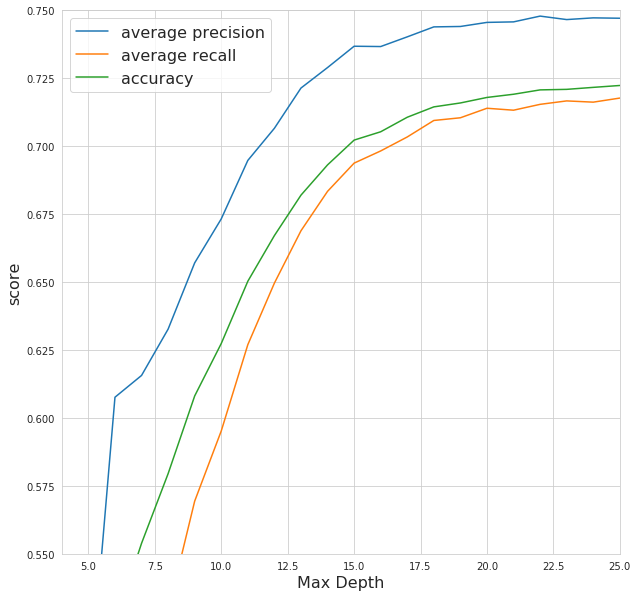

In [213]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(1,25,25),precision, label = 'average precision')
plt.plot(np.linspace(1,25,25),recall, label = 'average recall')
plt.plot(np.linspace(1,25,25),accuracy, label = 'accuracy')
plt.xlim(4,25)
plt.ylim(0.55,0.75)
plt.legend(fontsize=16)
plt.xlabel('Max Depth', fontsize=16)
plt.ylabel('score',fontsize=16)
plt.show()

In [215]:
rfc = RandomForestClassifier(max_depth=25)

In [231]:
y_pred = rfc.predict(X_train_scaled)
y_pred_ord = oe.transform(y_pred.reshape(-1,1))

In [234]:
recall_score(y_train_ord, y_pred_ord, average='macro')

0.9999881051504698

In [225]:
sorted(zip(rfc.feature_importances_,list(X.columns)), reverse=True)

[(0.1012201354621705, 'latitude'),
 (0.08954541452635516, 'mean_volume'),
 (0.08923384531334871, 'log_mass'),
 (0.08816440233034707, 'log_volume'),
 (0.08814094126765196, 'mean_mass'),
 (0.07017019647688803, 'mean_temp'),
 (0.06837011702302351, 'longitude'),
 (0.05811827660711173, 'mean_dwp'),
 (0.05761963736176503, 'diameter'),
 (0.049735428733736105, 'Biomass'),
 (0.04904213266475278, 'height'),
 (0.04841917552416823, 'volume'),
 (0.03365253099599428, 'county_code'),
 (0.031229945829656013, 'number_trees'),
 (0.028180188349352975, 'mean_prcp'),
 (0.025316348549079482, 'year'),
 (0.023841282984598262, 'state_code')]

In [235]:
#Testing various max depths (2-20)
depth_scores = np.empty((4,56133))
nest = [5, 10, 50, 100,200]
for i in range(len(nest)):
    rfc = RandomForestClassifier(n_estimators = nest[i], max_depth=8)
    depth_scores[i] = list(cross_val_predict(rfc, X_train_scaled, y_train_ord.ravel(), cv=5))

In [236]:
depth_scores

array([[8., 5., 8., ..., 8., 7., 5.],
       [1., 5., 9., ..., 8., 7., 5.],
       [1., 7., 9., ..., 8., 7., 5.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [239]:
precision = np.empty(4)
recall = np.empty(4)
accuracy = np.empty(4)
for i in range(4):
    precision[i] = precision_score(y_train_ord.ravel(), depth_scores[i], average = 'macro')
    recall[i] = recall_score(y_train_ord.ravel(),depth_scores[i], average = 'macro')
    accuracy[i] = accuracy_score(y_train_ord.ravel(),depth_scores[i])

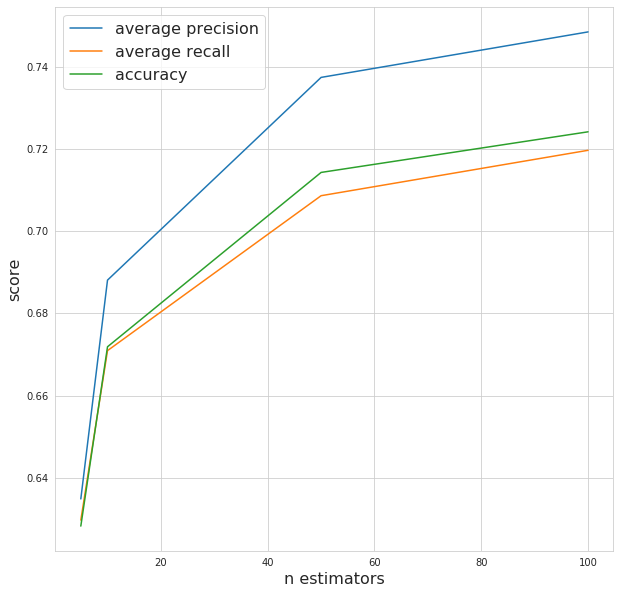

In [244]:
plt.figure(figsize=(10,10))
plt.plot(nest,precision, label = 'average precision')
plt.plot(nest,recall, label = 'average recall')
plt.plot(nest,accuracy, label = 'accuracy')
#plt.xlim(4,25)
#plt.ylim(0.55,0.75)
plt.legend(fontsize=16)
plt.xlabel('n estimators', fontsize=16)
plt.ylabel('score',fontsize=16)
plt.show()

In [288]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=8)

In [289]:
rfc.fit(X_train_scaled, y_train_ord.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [290]:
y_pred = rfc.predict(X_train_scaled)

In [291]:
precision_score(y_train_ord.ravel(),y_pred, average='macro')

0.6577598421144131